In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**NOTES:**
* Remove departure time because if you have that then you are on the plane already -> no reason to predict the delay time anymore
* Depature and arrival months can be different if the flight is at the end of the month
* Need more relevant continous-valued columns
* Temporarily remove the `flight_number` column for now, will think of better way to handle that col
* Certain values of attributes that are in val or test set are not in train set -> train transformation cannot apply

# Loading and cleaning data

In [5]:
filename = '/Users/longhoang/Desktop/airline-delay-prediction/data/airline-delay-small.csv' # replace with your 'csv' file path 😊

data = pd.read_csv(filename) # `df` stands for dataframe

cols_remove = ['Unnamed: 0', 'arr_time_utc', 'dep_time_utc', 'flight_number']
for col in cols_remove:
    data.drop(col, axis=1, inplace=True) # remove the column with no header
    
data.head()

,airline_iata,dep_estimated_utc,arr_estimated_utc,dep_country_code,arr_country_code,domestic,international,delayed
0,SQ,2023-10-05 01:22,2023-10-05 07:37,CN,SG,False,True,42
1,TR,2023-10-05 01:22,2023-10-05 07:37,CN,SG,False,True,42
2,7C,2023-10-05 02:24,2023-10-05 03:45,CN,KR,False,True,34
3,SC,2023-10-05 03:09,2023-10-05 04:09,CN,KR,False,True,34
4,CA,2023-10-05 03:09,2023-10-05 04:09,CN,KR,False,True,34


Split `dep_estimated_utc` and `arr_estimated_utc` into year, month, day, hour, minute

In [6]:
data[['date', 'time']] = data['dep_estimated_utc'].str.split(' ', expand=True)
data[['year', 'month', 'dep_est_day']] = data['date'].str.split('-', expand=True)
data[['dep_est_hour', 'dep_est_minute']] = data['time'].str.split(':', expand=True)

# convert to numeric
data[['year', 'month', 'dep_est_day', 'dep_est_hour', 'dep_est_minute']] = \
    data[['year', 'month', 'dep_est_day', 'dep_est_hour', 'dep_est_minute']].apply(pd.to_numeric)

data.drop(['date', 'time'], axis=1, inplace=True)

In [7]:
data[['date', 'time']] = data['arr_estimated_utc'].str.split(' ', expand=True)
data[['year', 'month', 'arr_est_day']] = data['date'].str.split('-', expand=True)
data[['arr_est_hour', 'arr_est_minute']] = data['time'].str.split(':', expand=True)

# convert to numeric
data[['year', 'month', 'arr_est_day', 'arr_est_hour', 'arr_est_minute']] = \
    data[['year', 'month', 'arr_est_day', 'arr_est_hour', 'arr_est_minute']].apply(pd.to_numeric)

data.drop(['date', 'time'], axis=1, inplace=True)

In [8]:
data.head(10)

,airline_iata,dep_estimated_utc,arr_estimated_utc,dep_country_code,arr_country_code,domestic,international,delayed,year,month,dep_est_day,dep_est_hour,dep_est_minute,arr_est_day,arr_est_hour,arr_est_minute
0,SQ,2023-10-05 01:22,2023-10-05 07:37,CN,SG,False,True,42,2023.0,10.0,5.0,1.0,22.0,5.0,7.0,37.0
1,TR,2023-10-05 01:22,2023-10-05 07:37,CN,SG,False,True,42,2023.0,10.0,5.0,1.0,22.0,5.0,7.0,37.0
2,7C,2023-10-05 02:24,2023-10-05 03:45,CN,KR,False,True,34,2023.0,10.0,5.0,2.0,24.0,5.0,3.0,45.0
3,SC,2023-10-05 03:09,2023-10-05 04:09,CN,KR,False,True,34,2023.0,10.0,5.0,3.0,9.0,5.0,4.0,9.0
4,CA,2023-10-05 03:09,2023-10-05 04:09,CN,KR,False,True,34,2023.0,10.0,5.0,3.0,9.0,5.0,4.0,9.0
5,OZ,2023-10-05 03:09,2023-10-05 04:09,CN,KR,False,True,34,2023.0,10.0,5.0,3.0,9.0,5.0,4.0,9.0
6,CA,2023-10-05 03:38,NaN,CN,KR,False,True,63,NaN,NaN,5.0,3.0,38.0,NaN,NaN,NaN
7,OZ,2023-10-05 03:38,NaN,CN,KR,False,True,63,NaN,NaN,5.0,3.0,38.0,NaN,NaN,NaN
8,SC,2023-10-05 03:38,NaN,CN,KR,False,True,63,NaN,NaN,5.0,3.0,38.0,NaN,NaN,NaN
9,SC,2023-10-05 03:40,2023-10-05 04:57,CN,CN,True,False,47,2023.0,10.0,5.0,3.0,40.0,5.0,4.0,57.0


In [9]:
(data.arr_est_day == data.dep_est_day).mean()
# departure and arrival days don't necessarily the same day

0.8931000971817298

In [10]:
data.drop(['dep_estimated_utc', 'arr_estimated_utc'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3087 entries, 0 to 3086
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline_iata      3071 non-null   object 
 1   dep_country_code  3087 non-null   object 
 2   arr_country_code  3087 non-null   object 
 3   domestic          3087 non-null   bool   
 4   international     3087 non-null   bool   
 5   delayed           3087 non-null   int64  
 6   year              2828 non-null   float64
 7   month             2828 non-null   float64
 8   dep_est_day       3029 non-null   float64
 9   dep_est_hour      3029 non-null   float64
 10  dep_est_minute    3029 non-null   float64
 11  arr_est_day       2828 non-null   float64
 12  arr_est_hour      2828 non-null   float64
 13  arr_est_minute    2828 non-null   float64
dtypes: bool(2), float64(8), int64(1), object(3)
memory usage: 295.6+ KB


In [11]:
# Let's see the statistics of delay time
data.delayed.describe()

count    3087.000000
mean      105.571429
std       131.775467
min        31.000000
25%        45.000000
50%        65.000000
75%       114.000000
max      1385.000000
Name: delayed, dtype: float64

The `mean` delay time is 105 (in minutes?) and `std` is 131 mins. The maximum delay time is 1385 mins which is quite high

Bin Edges: [31.   58.08]
Counts: 1337


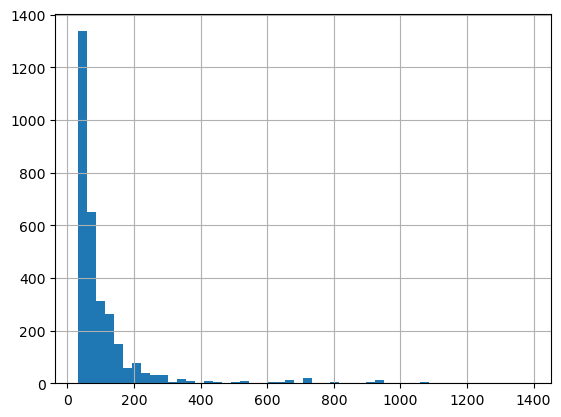

In [12]:
# Use the hist function to calculate the histogram and get the bin edges and counts
data.delayed.hist(bins=50)
counts, bin_edges = np.histogram(data['delayed'], bins=50)

# Print the bin edges and counts
print("Bin Edges:", bin_edges[0:2])
print("Counts:", counts[0])

So nearly half of the examples fall into the first bin. This phenomenom is call 'long tail', more specifically 'right long tail' which happens quite a lot. We will use one technique called Stratified Sampling to make sure train, valdiation, and test set have similar target distribution (delay time). 

You can see that the distribution seems to split into three part. 
- The first bin where nearly half of the data lie
- The second bin to the bin around 200 -- most of the remaining half
- The rest (from 200 to inf)

Let's do stratified sampling by splitting the data into 3 sets with similary distribution
based on 'delayed' attribute

<Axes: >

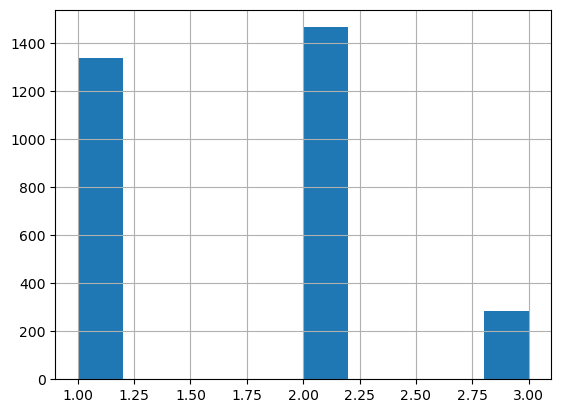

In [13]:
data['delay_bin'] = pd.cut(data.delayed, [0., 58, 200, np.inf], labels=[1,2,3])
data.delay_bin.hist()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_ix, test_ix in ss.split(data, data.delay_bin):
    train_val_set = data.iloc[train_ix]
    test_set = data.iloc[test_ix]

for train_ix, val_ix in ss.split(train_val_set, train_val_set.delay_bin):
    train_set = data.iloc[train_ix]
    val_set = data.iloc[val_ix]

/Users/longhoang/opt/anaconda3/envs/longhoang/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/longhoang/opt/anaconda3/envs/longhoang/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/longhoang/opt/anaconda3/envs/longhoang/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/longhoang/opt/anaconda3/envs/longhoang/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

In [15]:
# Check correctness
print(f'\nOrig: {len(data)} samples\n{data.delay_bin.value_counts() / len(data)}')
print(f'\nTrain: {len(train_set)} samples\n{train_set.delay_bin.value_counts() / len(train_set)}')
print(f'\nValidation: {len(val_set)} samples\n{val_set.delay_bin.value_counts() / len(train_set)}')
print(f'\nTest: {len(val_set)} samples\n{val_set.delay_bin.value_counts() / len(train_set)}')


Orig: 3087 samples
delay_bin
2    0.474895
1    0.433107
3    0.091999
Name: count, dtype: float64

Train: 1975 samples
delay_bin
2    0.489620
1    0.427848
3    0.082532
Name: count, dtype: float64

Validation: 494 samples
delay_bin
2    0.125063
1    0.106835
3    0.018228
Name: count, dtype: float64

Test: 494 samples
delay_bin
2    0.125063
1    0.106835
3    0.018228
Name: count, dtype: float64


In [16]:
# drop 'delay_bin' column
for set_ in (train_set, val_set, test_set):
    set_.drop('delay_bin', axis=1, inplace=True)

/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_17206/1214186903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop('delay_bin', axis=1, inplace=True)
/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_17206/1214186903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop('delay_bin', axis=1, inplace=True)
/var/folders/fy/f4c573kn4x3462qpp_j4d_h80000gn/T/ipykernel_17206/1214186903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Since the number of attributes is quite small, we can try to find the correlation dataset and see which feature influences the target the most

In [17]:
cm = train_set.corr()
cm['delayed'].sort_values(ascending=False)

ValueError: could not convert string to float: 'NH'

Visualize the influence of Estimated departure hour on the delay time

Text(0, 0.5, 'Delay time')

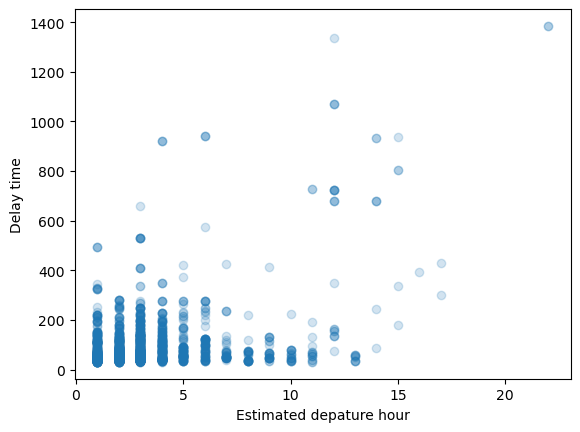

In [ ]:
plt.scatter(train_set.dep_est_hour, train_set.delayed, marker='o', alpha=0.2)
plt.xlabel('Estimated depature hour')
plt.ylabel('Delay time')

In [ ]:
train_set.delayed.max()

1385

?? Some guys have delay time of 1385 minutes (23 hours)

Text(0, 0.5, 'Delay time')

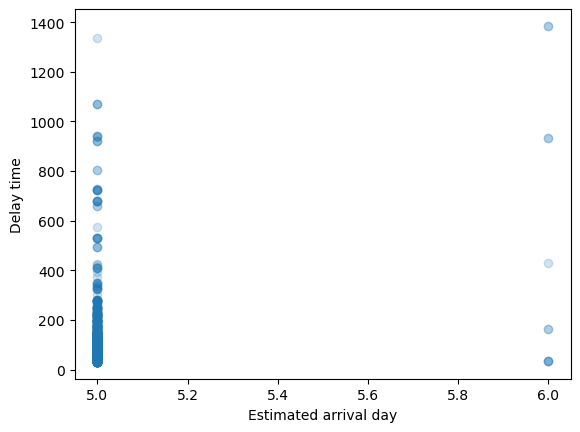

In [ ]:
plt.scatter(train_set.arr_est_day, train_set.delayed, marker='o', alpha=0.2)
plt.xlabel('Estimated arrival day')
plt.ylabel('Delay time')

There is too little data for this feature to say anything 🥲

In [ ]:
train_set.head()

,airline_iata,dep_country_code,arr_country_code,domestic,international,delayed,year,month,dep_est_day,dep_est_hour,dep_est_minute,arr_est_day,arr_est_hour,arr_est_minute
1512,NH,JP,JP,True,False,43,2023.0,10.0,5.0,1.0,23.0,5.0,3.0,13.0
199,JQ,AU,AU,True,False,56,2023.0,10.0,5.0,1.0,51.0,5.0,3.0,50.0
786,UA,US,US,True,False,49,2023.0,10.0,5.0,2.0,51.0,5.0,5.0,16.0
476,BR,JP,TW,False,True,50,NaN,NaN,5.0,5.0,0.0,NaN,NaN,NaN
646,WN,US,US,True,False,88,2023.0,10.0,5.0,4.0,0.0,5.0,5.0,8.0


# Preprocessing data for ML model

In [ ]:
train_data = train_set.drop('delayed', axis=1)
train_labels = train_set['delayed'].copy()

There are some columns with missing values (NaN). Let's deal with that

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 1512 to 1169
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline_iata      1968 non-null   object 
 1   dep_country_code  1975 non-null   object 
 2   arr_country_code  1975 non-null   object 
 3   domestic          1975 non-null   bool   
 4   international     1975 non-null   bool   
 5   year              1834 non-null   float64
 6   month             1834 non-null   float64
 7   dep_est_day       1951 non-null   float64
 8   dep_est_hour      1951 non-null   float64
 9   dep_est_minute    1951 non-null   float64
 10  arr_est_day       1834 non-null   float64
 11  arr_est_hour      1834 non-null   float64
 12  arr_est_minute    1834 non-null   float64
dtypes: bool(2), float64(8), object(3)
memory usage: 189.0+ KB


In [ ]:
cat_cols = ['airline_iata', 'dep_country_code', 'arr_country_code']
bool_cols = ['domestic', 'international']

num_cols = list(set(train_data) - set(cat_cols) - set(bool_cols))

print(f'Numerical attributes: {num_cols}')
print(f'Boolean attributes: {bool_cols}')
print(f'Categorical attributes: {cat_cols}')

Numerical attributes: ['arr_est_hour', 'arr_est_minute', 'dep_est_day', 'arr_est_day', 'dep_est_minute', 'year', 'month', 'dep_est_hour']
Boolean attributes: ['domestic', 'international']
Categorical attributes: ['airline_iata', 'dep_country_code', 'arr_country_code']


Creating processing pipeline for each type of attributes and then combining them all together

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('medi_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

full_pipline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('bool', OneHotEncoder(), bool_cols)
])

In [ ]:
train_data_ready = full_pipline.fit_transform(train_data)
train_data_ready

<1975x266 sparse matrix of type '<class 'numpy.float64'>'
	with 19750 stored elements in Compressed Sparse Row format>

# Training models

Trying the simplest possible model for regression: Linear regression, and see how it does

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_data_ready, train_labels)

train_preds_lin_reg = lin_reg.predict(train_data_ready)
lin_reg_mse = mean_squared_error(train_labels, train_preds_lin_reg)
np.sqrt(lin_reg_mse)

98.15722447321252

Prediction error of 98 minutes is not really good. Let's use better model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_data_ready, train_labels)

# see if it fits the traind data well
train_preds = tree_reg.predict(train_data_ready)
tree_mse = mean_squared_error(train_labels, train_preds)
np.sqrt(tree_mse)

3.8536299945663046

Look much better but the model might be overfitting so let's test it with `Cross validation`

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_data_ready, train_labels, 
                         scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Std:', scores.std())

In [ ]:
display_scores(tree_rmse_scores)

Scores: [113.96056934 110.0784844   43.06631016 105.32769931  50.26384929
  89.78045699  95.53554631  72.91149728  86.51832939  48.14924977]
Mean: 81.55919922344553
Std: 25.23443925434493


In [ ]:
# Do cross val with linear regression
lin_scores = cross_val_score(lin_reg, train_data_ready, train_labels, 
                         scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [107.01989698 124.32221124 106.40378875 135.57890948 109.85052482
 101.07654625 102.94451368 140.37059245 127.52893441 122.33930221]
Mean: 117.74352202820532
Std: 13.390010545138042


Decision tree seems to do a better job than linear regression, though it has more error fluctation (higher standard deviation). Let's try one of the best model for tabular data, random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(train_data_ready, train_labels)

train_preds = forest_reg.predict(train_data_ready)
train_forest_mse = mean_squared_error(train_labels, train_preds)
train_forest_rmse = np.sqrt(train_forest_mse)
print('Train loss:', train_forest_rmse)

Train loss: 26.1163955140791


In [ ]:
forest_scores = cross_val_score(forest_reg, train_data_ready, train_labels, 
                         scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
print('Cross validation losses:')
display_scores(forest_rmse_scores)

Cross validation losses:
Scores: [75.43013347 98.47513772 66.25407385 92.82782995 48.40012257 51.08456863
 71.36861144 72.66061218 78.83343648 48.16534586]
Mean: 70.34998721458102
Std: 16.620224472883717


Random forest seems to do better than decision tree in terms of smaller error variation (lower standard deviation). However, the model is overfitting since the train loss is much smaller than validation losses

# Tuning hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [1, 3, 10, 30, 50, 100], 
     'max_features': [1, 3, 10, 30, 100, 150, 200, 250], 
     'bootstrap': [False, True],
     'max_depth': [1, 3, 10, 30, 50, 100]}
]

model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# grid_search.fit(train_data_ready, train_labels) # uncomment this to do grid search

In [ ]:
# UNCOMMENT 2 LINES BELOW TO GET THE BEST MODEL FROM GRID SEARCH
# print(grid_search.best_params_)
# model_tuned = grid_search.best_estimator_

# Best model from grid search
model_tuned = RandomForestRegressor(n_estimators=10,
                                    max_depth=100,
                                    max_features=100,
                                    bootstrap=False)

In [ ]:
forest_scores = cross_val_score(model_tuned, train_data_ready, train_labels, 
                         scoring='neg_mean_squared_error', cv=5)

forest_rmse_scores = np.sqrt(-forest_scores)
print('Cross validation losses:')
display_scores(forest_rmse_scores)

Cross validation losses:
Scores: [101.36791627  85.41065318  57.98105016  57.32779265  70.68609911]
Mean: 74.55470227465926
Std: 16.871387407107758


# Analyze model

In [ ]:
model_tuned.fit(train_data_ready, train_labels)
feature_importances = model_tuned.feature_importances_
feature_importances

array([1.36863039e-01, 1.57619700e-01, 0.00000000e+00, 3.09957854e-02,
       1.43231522e-01, 0.00000000e+00, 0.00000000e+00, 2.89876860e-01,
       1.10135637e-04, 1.15496128e-05, 1.72643148e-03, 0.00000000e+00,
       2.04248245e-05, 5.34642742e-04, 1.99521864e-04, 0.00000000e+00,
       2.47213187e-05, 3.82978488e-05, 0.00000000e+00, 4.19334638e-09,
       0.00000000e+00, 1.17936626e-05, 7.44517679e-05, 0.00000000e+00,
       4.02810633e-03, 1.04082179e-03, 3.46456293e-05, 2.36441202e-04,
       6.94984173e-05, 4.89703513e-03, 3.97312728e-05, 1.87450237e-04,
       1.00640313e-08, 1.31547829e-03, 0.00000000e+00, 2.56612087e-04,
       1.86386819e-08, 0.00000000e+00, 5.82152990e-03, 1.49066536e-03,
       3.25088064e-05, 0.00000000e+00, 8.73930658e-05, 4.22224787e-05,
       3.99324015e-05, 2.94984228e-05, 4.65804734e-04, 3.79366056e-07,
       4.37725183e-03, 3.27553220e-04, 3.22125245e-07, 2.59490049e-06,
       1.78308356e-05, 5.04760503e-04, 9.57111021e-07, 8.51314875e-06,
      

In [ ]:
cat_encoder = full_pipline.named_transformers_['cat'].named_steps['one_hot_encoder']
# cat_encoder.categories_[0]

In [ ]:
bool_encoder = full_pipline.named_transformers_['bool']
# bool_encoder.categories_[0]

`WARNING: The sorted list of feature importance might not be correct`

In [ ]:
attrs = num_cols + list(cat_encoder.categories_[0]) + list(bool_encoder.categories_[0])
# len(attrs)
sorted(zip(feature_importances, attrs), reverse=True)

[(0.2898768604249869, 'dep_est_hour'),
 (0.15761970046296844, 'arr_est_minute'),
 (0.1432315221821403, 'dep_est_minute'),
 (0.1368630391270865, 'arr_est_hour'),
 (0.030995785406574588, 'arr_est_day'),
 (0.015079862491626617, 'JQ'),
 (0.009930367835118786, 'LA'),
 (0.008492134613610255, 'UA'),
 (0.0058751752156177076, 'HA'),
 (0.005821529903697326, 'B6'),
 (0.005740064583485796, 'JA'),
 (0.005616867456817843, 'ZL'),
 (0.0048970351296360164, 'AK'),
 (0.0043772518293087185, 'DL'),
 (0.004298999110538675, 'WN'),
 (0.004028106333080711, 'AA'),
 (0.0031248491628019072, 'QF'),
 (0.0025982487462127813, 'QR'),
 (0.0017751191184168075, 'JL'),
 (0.0017264314774827268, '3U'),
 (0.0014906653641775535, 'BA'),
 (0.0013868437374133173, 'YV'),
 (0.0013154782949234807, 'AS'),
 (0.001053664427708302, 'YX'),
 (0.0010408217853629595, 'AC'),
 (0.0008675296055079185, 'NZ'),
 (0.0007485728737553309, 'TG'),
 (0.0007479405030952331, 'IB'),
 (0.0007153538820531563, 'G3'),
 (0.0006925418334246126, 'GF'),
 (0.0006

# Evaluating

In [ ]:
val_data = val_set.drop('delayed', axis=1)
val_labels = val_set['delayed'].copy()

In [ ]:
len(val_data)

494

In [ ]:
val_data_ready = full_pipline.transform(val_data)
val_preds = model_tuned.predict(val_data_ready)

val_mse = mean_squared_error(val_labels, val_preds)
val_rmse = np.sqrt(val_mse)
val_rmse

60.71484830556963

Compute 95% confidence interval

In [ ]:
from scipy import stats

confidence = 0.95
squared_error = (val_preds - val_labels) ** 2
np.sqrt(stats.t.interval(
    confidence, len(squared_error) - 1,
    loc = squared_error.mean(),
    scale = stats.sem(squared_error)
))

array([34.59999977, 78.58387637])

That means 95% of the time the prediction error gap will lie in the range from 34.6 to 78.6 minutes

TODO:
- Analyze historical data + predict new data